# ConvNet LSTM in Keras

In this notebook, we use a *bidirectional* LSTM to classify IMDB movie reviews by their sentiment with a *Convolutional-Bidirectional LSTM Stack*

#### Load dependencies

In [3]:
import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, SpatialDropout1D, LSTM, Conv1D, MaxPooling1D
from keras.layers.wrappers import Bidirectional # new! 
from keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt 
%matplotlib inline

#### Set hyperparameters

In [4]:
# output directory name:
output_dir = 'model_output/convBiLSTM'

# training:
epochs = 4
batch_size = 128

# vector-space embedding: 
n_dim = 64 
n_unique_words = 10000 
max_review_length = 200 # doubled!
pad_type = trunc_type = 'pre'
drop_embed = 0.2 

#Conv Layer
n_conv=64
k_conv=3
mp_size = 4

# LSTM layer architecture:
n_lstm = 64 
drop_lstm = 0.2

#### Load data

In [5]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words) # removed n_words_to_skip

#### Preprocess data

In [6]:
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

#### Design neural network architecture

In [9]:
model = Sequential()
model.add(Embedding(n_unique_words, n_dim, input_length=max_review_length)) 
model.add(SpatialDropout1D(drop_embed))
model.add(Conv1D(n_conv, k_conv, activation='relu'))
model.add(MaxPooling1D(mp_size))
model.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm)))
model.add(Dense(1, activation='sigmoid'))

In [10]:
# LSTM layer parameters double due to both reading directions
model.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 64)           640000    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 200, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 198, 64)           12352     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 49, 64)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 718,529
Trainable params: 718,529
Non-trainable params: 0
_________________________________________________________________


#### Configure model

In [11]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [12]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### Train!

In [13]:
# - we see 87.0% validation accuracy in epoch 2
# - with this toy dataset, the complex interplay of words over long sentence segments, won't be learned much
# - so our CNN picking up location-invariant segments of two to four words that predict review sentiment
# - these are simpler and so easier to learn from the data
# - CNN therefore outperforms on the IMDB data set
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])

Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 48s 2ms/step - loss: 0.4648 - acc: 0.7537 - val_loss: 0.3077 - val_acc: 0.8713
Epoch 2/4
25000/25000 [==============================] - 44s 2ms/step - loss: 0.2407 - acc: 0.9062 - val_loss: 0.3100 - val_acc: 0.8697
Epoch 3/4
25000/25000 [==============================] - 43s 2ms/step - loss: 0.1804 - acc: 0.9320 - val_loss: 0.3300 - val_acc: 0.8640
Epoch 4/4
25000/25000 [==============================] - 44s 2ms/step - loss: 0.1381 - acc: 0.9500 - val_loss: 0.3725 - val_acc: 0.8571


#### Evaluate

In [24]:
model.load_weights(output_dir+"/weights.01.hdf5") # zero-indexed

In [25]:
y_hat = model.predict_proba(x_valid)

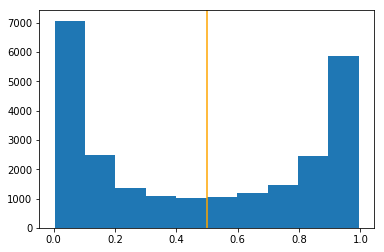

In [26]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [27]:
"{:0.2f}".format(roc_auc_score(y_valid, y_hat)*100.0)

'94.50'